## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-03-24 22:54:03--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  71.3MB/s    in 4.4s    

2020-03-24 22:54:08 (73.2 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (fc1): Linear(in_features=12800, out_features=1000, bias=True)
  (drop4): Dropout(p=0.4)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (drop5): Dropout(p=0.5)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(100),
                                     RandomCrop(96),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

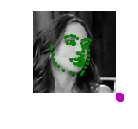

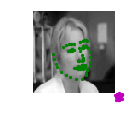

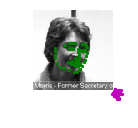

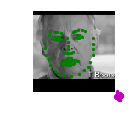

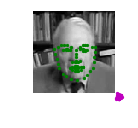

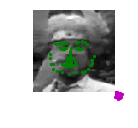

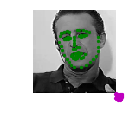

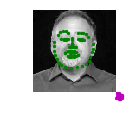

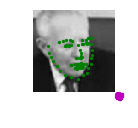

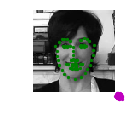

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [19]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.011311256140470505
Epoch: 1, Batch: 20, Avg. Loss: 0.012007712991908193
Epoch: 1, Batch: 30, Avg. Loss: 0.01116855964064598
Epoch: 1, Batch: 40, Avg. Loss: 0.010871239798143506
Epoch: 1, Batch: 50, Avg. Loss: 0.019993783719837666
Epoch: 1, Batch: 60, Avg. Loss: 0.010729353642091155
Epoch: 1, Batch: 70, Avg. Loss: 0.01202891762368381
Epoch: 1, Batch: 80, Avg. Loss: 0.011608223337680102
Epoch: 1, Batch: 90, Avg. Loss: 0.009949745517224074
Epoch: 1, Batch: 100, Avg. Loss: 0.017658922448754312
Epoch: 1, Batch: 110, Avg. Loss: 0.012552988808602094
Epoch: 1, Batch: 120, Avg. Loss: 0.009680701233446599
Epoch: 1, Batch: 130, Avg. Loss: 0.011500004678964615
Epoch: 1, Batch: 140, Avg. Loss: 0.009410943975672126
Epoch: 1, Batch: 150, Avg. Loss: 0.009073872026056052
Epoch: 1, Batch: 160, Avg. Loss: 0.011274327989667654
Epoch: 1, Batch: 170, Avg. Loss: 0.009739916352555156


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.011049564648419618
Epoch: 2, Batch: 20, Avg. Loss: 0.009632445871829987
Epoch: 2, Batch: 30, Avg. Loss: 0.011665005050599576
Epoch: 2, Batch: 40, Avg. Loss: 0.01073755118995905
Epoch: 2, Batch: 50, Avg. Loss: 0.01282234312966466
Epoch: 2, Batch: 60, Avg. Loss: 0.01165419016033411
Epoch: 2, Batch: 70, Avg. Loss: 0.014063535910099744
Epoch: 2, Batch: 80, Avg. Loss: 0.018139445502310992
Epoch: 2, Batch: 90, Avg. Loss: 0.012045855121687054
Epoch: 2, Batch: 100, Avg. Loss: 0.012217342108488082
Epoch: 2, Batch: 110, Avg. Loss: 0.01081073353998363
Epoch: 2, Batch: 120, Avg. Loss: 0.01085907369852066
Epoch: 2, Batch: 130, Avg. Loss: 0.010987325804308057
Epoch: 2, Batch: 140, Avg. Loss: 0.009248513029888272
Epoch: 2, Batch: 150, Avg. Loss: 0.010275193396955729
Epoch: 2, Batch: 160, Avg. Loss: 0.01233246447518468
Epoch: 2, Batch: 170, Avg. Loss: 0.010006493469700218


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.008991925092414022
Epoch: 3, Batch: 20, Avg. Loss: 0.010845300368964672
Epoch: 3, Batch: 30, Avg. Loss: 0.009878319269046188
Epoch: 3, Batch: 40, Avg. Loss: 0.011116398498415947
Epoch: 3, Batch: 50, Avg. Loss: 0.009826641902327538
Epoch: 3, Batch: 60, Avg. Loss: 0.011067608091980218
Epoch: 3, Batch: 70, Avg. Loss: 0.011313264397904277
Epoch: 3, Batch: 80, Avg. Loss: 0.014878529217094183
Epoch: 3, Batch: 90, Avg. Loss: 0.009329097066074609
Epoch: 3, Batch: 100, Avg. Loss: 0.012407743139192462
Epoch: 3, Batch: 110, Avg. Loss: 0.009128700057044626
Epoch: 3, Batch: 120, Avg. Loss: 0.0097360298037529
Epoch: 3, Batch: 130, Avg. Loss: 0.009937854064628483
Epoch: 3, Batch: 140, Avg. Loss: 0.013228568900376558
Epoch: 3, Batch: 150, Avg. Loss: 0.026840593107044695
Epoch: 3, Batch: 160, Avg. Loss: 0.011044969223439694
Epoch: 3, Batch: 170, Avg. Loss: 0.01128104105591774


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.009988273866474629
Epoch: 4, Batch: 20, Avg. Loss: 0.009534600004553796
Epoch: 4, Batch: 30, Avg. Loss: 0.017714283568784593
Epoch: 4, Batch: 40, Avg. Loss: 0.012507714238017798
Epoch: 4, Batch: 50, Avg. Loss: 0.009354973025619984
Epoch: 4, Batch: 60, Avg. Loss: 0.011074273474514484
Epoch: 4, Batch: 70, Avg. Loss: 0.009775624703615904
Epoch: 4, Batch: 80, Avg. Loss: 0.009385410603135825
Epoch: 4, Batch: 90, Avg. Loss: 0.009305082261562347
Epoch: 4, Batch: 100, Avg. Loss: 0.009592868480831384
Epoch: 4, Batch: 110, Avg. Loss: 0.010292403865605593
Epoch: 4, Batch: 120, Avg. Loss: 0.009166652057319879
Epoch: 4, Batch: 130, Avg. Loss: 0.00855553075671196
Epoch: 4, Batch: 140, Avg. Loss: 0.009116779826581479
Epoch: 4, Batch: 150, Avg. Loss: 0.009517985116690397
Epoch: 4, Batch: 160, Avg. Loss: 0.01123099522665143
Epoch: 4, Batch: 170, Avg. Loss: 0.011048265406861902


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.011646669870242477
Epoch: 5, Batch: 20, Avg. Loss: 0.008763793762773276
Epoch: 5, Batch: 30, Avg. Loss: 0.007798372628167271
Epoch: 5, Batch: 40, Avg. Loss: 0.008368134312331677
Epoch: 5, Batch: 50, Avg. Loss: 0.011670939344912767
Epoch: 5, Batch: 60, Avg. Loss: 0.010708562424406409
Epoch: 5, Batch: 70, Avg. Loss: 0.009409496933221817
Epoch: 5, Batch: 80, Avg. Loss: 0.014704024326056242
Epoch: 5, Batch: 90, Avg. Loss: 0.010871125850826502
Epoch: 5, Batch: 100, Avg. Loss: 0.009484567726030946
Epoch: 5, Batch: 110, Avg. Loss: 0.009004931338131428
Epoch: 5, Batch: 120, Avg. Loss: 0.011190577084198594
Epoch: 5, Batch: 130, Avg. Loss: 0.013611054141074419
Epoch: 5, Batch: 140, Avg. Loss: 0.01188197648152709
Epoch: 5, Batch: 150, Avg. Loss: 0.010547376191243529
Epoch: 5, Batch: 160, Avg. Loss: 0.010339466156437993
Epoch: 5, Batch: 170, Avg. Loss: 0.020320614147931338


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.009542794805020094
Epoch: 6, Batch: 20, Avg. Loss: 0.009586884221062065
Epoch: 6, Batch: 30, Avg. Loss: 0.015624367166310549
Epoch: 6, Batch: 40, Avg. Loss: 0.010894128121435642
Epoch: 6, Batch: 50, Avg. Loss: 0.008630289509892464
Epoch: 6, Batch: 60, Avg. Loss: 0.009292014176025987
Epoch: 6, Batch: 70, Avg. Loss: 0.011355348583310842
Epoch: 6, Batch: 80, Avg. Loss: 0.00940599194727838
Epoch: 6, Batch: 90, Avg. Loss: 0.010137595422565936
Epoch: 6, Batch: 100, Avg. Loss: 0.009640344697982074
Epoch: 6, Batch: 110, Avg. Loss: 0.009216671297326683
Epoch: 6, Batch: 120, Avg. Loss: 0.009056412382051349
Epoch: 6, Batch: 130, Avg. Loss: 0.00833933725953102
Epoch: 6, Batch: 140, Avg. Loss: 0.009386282926425338
Epoch: 6, Batch: 150, Avg. Loss: 0.012948973663151264
Epoch: 6, Batch: 160, Avg. Loss: 0.00978047912940383
Epoch: 6, Batch: 170, Avg. Loss: 0.010107124550268054


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.009434934193268418
Epoch: 7, Batch: 20, Avg. Loss: 0.025324581656605005
Epoch: 7, Batch: 30, Avg. Loss: 0.010069616045802832
Epoch: 7, Batch: 40, Avg. Loss: 0.011421334370970726
Epoch: 7, Batch: 50, Avg. Loss: 0.01079645100980997
Epoch: 7, Batch: 60, Avg. Loss: 0.01307960543781519
Epoch: 7, Batch: 70, Avg. Loss: 0.00938716153614223
Epoch: 7, Batch: 80, Avg. Loss: 0.00798854073509574
Epoch: 7, Batch: 90, Avg. Loss: 0.011381077347323298
Epoch: 7, Batch: 100, Avg. Loss: 0.011493982188403607
Epoch: 7, Batch: 110, Avg. Loss: 0.012707297503948212
Epoch: 7, Batch: 120, Avg. Loss: 0.01085812458768487
Epoch: 7, Batch: 130, Avg. Loss: 0.009195298422127962
Epoch: 7, Batch: 140, Avg. Loss: 0.008901298791170121
Epoch: 7, Batch: 150, Avg. Loss: 0.009515275852754712
Epoch: 7, Batch: 160, Avg. Loss: 0.00909651480615139
Epoch: 7, Batch: 170, Avg. Loss: 0.010277267498895525


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.008401403995230794
Epoch: 8, Batch: 20, Avg. Loss: 0.008555212058126926
Epoch: 8, Batch: 30, Avg. Loss: 0.009785618539899588
Epoch: 8, Batch: 40, Avg. Loss: 0.013401386328041553
Epoch: 8, Batch: 50, Avg. Loss: 0.009342572977766394
Epoch: 8, Batch: 60, Avg. Loss: 0.008211909094825387
Epoch: 8, Batch: 70, Avg. Loss: 0.009848804213106632
Epoch: 8, Batch: 80, Avg. Loss: 0.01015492994338274
Epoch: 8, Batch: 90, Avg. Loss: 0.01078368746675551
Epoch: 8, Batch: 100, Avg. Loss: 0.009890873217955232
Epoch: 8, Batch: 110, Avg. Loss: 0.009302176628261804
Epoch: 8, Batch: 120, Avg. Loss: 0.007953122816979885
Epoch: 8, Batch: 130, Avg. Loss: 0.008727734023705126
Epoch: 8, Batch: 140, Avg. Loss: 0.00880860686302185
Epoch: 8, Batch: 150, Avg. Loss: 0.01087904036976397
Epoch: 8, Batch: 160, Avg. Loss: 0.007808564789593219
Epoch: 8, Batch: 170, Avg. Loss: 0.008206029934808613


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.007927690492942929
Epoch: 9, Batch: 20, Avg. Loss: 0.010346298012882471
Epoch: 9, Batch: 30, Avg. Loss: 0.008848979650065304
Epoch: 9, Batch: 40, Avg. Loss: 0.007460868172347546
Epoch: 9, Batch: 50, Avg. Loss: 0.008379969792440534
Epoch: 9, Batch: 60, Avg. Loss: 0.009009246109053492
Epoch: 9, Batch: 70, Avg. Loss: 0.0103680610191077
Epoch: 9, Batch: 80, Avg. Loss: 0.00824816906824708
Epoch: 9, Batch: 90, Avg. Loss: 0.007222678465768695
Epoch: 9, Batch: 100, Avg. Loss: 0.008580547757446766
Epoch: 9, Batch: 110, Avg. Loss: 0.016455968422815204
Epoch: 9, Batch: 120, Avg. Loss: 0.008933238917961717
Epoch: 9, Batch: 130, Avg. Loss: 0.009107079915702343
Epoch: 9, Batch: 140, Avg. Loss: 0.016363220661878584
Epoch: 9, Batch: 150, Avg. Loss: 0.009402279742062092
Epoch: 9, Batch: 160, Avg. Loss: 0.010240855207666755
Epoch: 9, Batch: 170, Avg. Loss: 0.008781514829024673


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.007277911948040128
Epoch: 10, Batch: 20, Avg. Loss: 0.010096520557999611
Epoch: 10, Batch: 30, Avg. Loss: 0.012222017487511038
Epoch: 10, Batch: 40, Avg. Loss: 0.008538768347352742
Epoch: 10, Batch: 50, Avg. Loss: 0.008935130760073661
Epoch: 10, Batch: 60, Avg. Loss: 0.007383380550891161
Epoch: 10, Batch: 70, Avg. Loss: 0.00791781353764236
Epoch: 10, Batch: 80, Avg. Loss: 0.007482867268845439
Epoch: 10, Batch: 90, Avg. Loss: 0.00906656258739531
Epoch: 10, Batch: 100, Avg. Loss: 0.007692188303917646
Epoch: 10, Batch: 110, Avg. Loss: 0.007855946104973555
Epoch: 10, Batch: 120, Avg. Loss: 0.009706306084990502
Epoch: 10, Batch: 130, Avg. Loss: 0.020557671179994942
Epoch: 10, Batch: 140, Avg. Loss: 0.009253895096480846
Epoch: 10, Batch: 150, Avg. Loss: 0.009780855290591717
Epoch: 10, Batch: 160, Avg. Loss: 0.012554826913401484
Epoch: 10, Batch: 170, Avg. Loss: 0.008824915532022715


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.011859323782846331
Epoch: 11, Batch: 20, Avg. Loss: 0.016527670761570336
Epoch: 11, Batch: 30, Avg. Loss: 0.008127289405092598
Epoch: 11, Batch: 40, Avg. Loss: 0.009160300716757774
Epoch: 11, Batch: 50, Avg. Loss: 0.008312245132401586
Epoch: 11, Batch: 60, Avg. Loss: 0.0075191966723650696
Epoch: 11, Batch: 70, Avg. Loss: 0.011167266871780157
Epoch: 11, Batch: 80, Avg. Loss: 0.008622882422059774
Epoch: 11, Batch: 90, Avg. Loss: 0.007825394766405225
Epoch: 11, Batch: 100, Avg. Loss: 0.009827339695766569
Epoch: 11, Batch: 110, Avg. Loss: 0.009593121334910392
Epoch: 11, Batch: 120, Avg. Loss: 0.007231556577607989
Epoch: 11, Batch: 130, Avg. Loss: 0.007794995605945587
Epoch: 11, Batch: 140, Avg. Loss: 0.006882627075538039
Epoch: 11, Batch: 150, Avg. Loss: 0.007264352310448885
Epoch: 11, Batch: 160, Avg. Loss: 0.007707966584712267
Epoch: 11, Batch: 170, Avg. Loss: 0.00854687080718577


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.008062414638698102
Epoch: 12, Batch: 20, Avg. Loss: 0.00934512889944017
Epoch: 12, Batch: 30, Avg. Loss: 0.008655594754964113
Epoch: 12, Batch: 40, Avg. Loss: 0.012932617589831353
Epoch: 12, Batch: 50, Avg. Loss: 0.007839896297082306
Epoch: 12, Batch: 60, Avg. Loss: 0.0098658780567348
Epoch: 12, Batch: 70, Avg. Loss: 0.010963799525052309
Epoch: 12, Batch: 80, Avg. Loss: 0.009701541159301996
Epoch: 12, Batch: 90, Avg. Loss: 0.010661502741277218
Epoch: 12, Batch: 100, Avg. Loss: 0.011529028555378318
Epoch: 12, Batch: 110, Avg. Loss: 0.013317016232758761
Epoch: 12, Batch: 120, Avg. Loss: 0.008491973858326674
Epoch: 12, Batch: 130, Avg. Loss: 0.007289052242413163
Epoch: 12, Batch: 140, Avg. Loss: 0.007461789017543197
Epoch: 12, Batch: 150, Avg. Loss: 0.00820756801404059
Epoch: 12, Batch: 160, Avg. Loss: 0.00910611292347312
Epoch: 12, Batch: 170, Avg. Loss: 0.007835435494780541


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.008558610873296856
Epoch: 13, Batch: 20, Avg. Loss: 0.0077171870972961186
Epoch: 13, Batch: 30, Avg. Loss: 0.008978471392765641
Epoch: 13, Batch: 40, Avg. Loss: 0.009073303639888763
Epoch: 13, Batch: 50, Avg. Loss: 0.00614771069958806
Epoch: 13, Batch: 60, Avg. Loss: 0.007131896959617734
Epoch: 13, Batch: 70, Avg. Loss: 0.01288247127085924
Epoch: 13, Batch: 80, Avg. Loss: 0.007600187114439905
Epoch: 13, Batch: 90, Avg. Loss: 0.008646702067926526
Epoch: 13, Batch: 100, Avg. Loss: 0.007173968758434057
Epoch: 13, Batch: 110, Avg. Loss: 0.007527473801746965
Epoch: 13, Batch: 120, Avg. Loss: 0.007533594034612179
Epoch: 13, Batch: 130, Avg. Loss: 0.007262646360322833
Epoch: 13, Batch: 140, Avg. Loss: 0.009173320606350899
Epoch: 13, Batch: 150, Avg. Loss: 0.00859700539149344
Epoch: 13, Batch: 160, Avg. Loss: 0.010965482145547868
Epoch: 13, Batch: 170, Avg. Loss: 0.013163922633975745


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.007731490070000291
Epoch: 14, Batch: 20, Avg. Loss: 0.008364530419930816
Epoch: 14, Batch: 30, Avg. Loss: 0.009205479267984628
Epoch: 14, Batch: 40, Avg. Loss: 0.008015539590269327
Epoch: 14, Batch: 50, Avg. Loss: 0.008294541202485562
Epoch: 14, Batch: 60, Avg. Loss: 0.015184691920876504
Epoch: 14, Batch: 70, Avg. Loss: 0.007704807352274657
Epoch: 14, Batch: 80, Avg. Loss: 0.00844441018998623
Epoch: 14, Batch: 90, Avg. Loss: 0.01283971332013607
Epoch: 14, Batch: 100, Avg. Loss: 0.00922486362978816
Epoch: 14, Batch: 110, Avg. Loss: 0.008297705324366689
Epoch: 14, Batch: 120, Avg. Loss: 0.008955862745642662
Epoch: 14, Batch: 130, Avg. Loss: 0.0069661644287407395
Epoch: 14, Batch: 140, Avg. Loss: 0.006823499407619238
Epoch: 14, Batch: 150, Avg. Loss: 0.0073942116927355524
Epoch: 14, Batch: 160, Avg. Loss: 0.007803723914548755
Epoch: 14, Batch: 170, Avg. Loss: 0.011382843600586057


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.007762548420578242
Epoch: 15, Batch: 20, Avg. Loss: 0.01392366481013596
Epoch: 15, Batch: 30, Avg. Loss: 0.006911686481907963
Epoch: 15, Batch: 40, Avg. Loss: 0.007482767477631569
Epoch: 15, Batch: 50, Avg. Loss: 0.007962929178029298
Epoch: 15, Batch: 60, Avg. Loss: 0.011647057440131902
Epoch: 15, Batch: 70, Avg. Loss: 0.008863922441378236
Epoch: 15, Batch: 80, Avg. Loss: 0.008198970183730125
Epoch: 15, Batch: 90, Avg. Loss: 0.008029519207775592
Epoch: 15, Batch: 100, Avg. Loss: 0.006790283089503646
Epoch: 15, Batch: 110, Avg. Loss: 0.008075682818889618
Epoch: 15, Batch: 120, Avg. Loss: 0.0077749814838171
Epoch: 15, Batch: 130, Avg. Loss: 0.007990766502916812
Epoch: 15, Batch: 140, Avg. Loss: 0.0070566421840339896
Epoch: 15, Batch: 150, Avg. Loss: 0.009177902713418007
Epoch: 15, Batch: 160, Avg. Loss: 0.007714390382170677
Epoch: 15, Batch: 170, Avg. Loss: 0.010052120871841907


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.008068272098898887
Epoch: 16, Batch: 20, Avg. Loss: 0.008373434888198972
Epoch: 16, Batch: 30, Avg. Loss: 0.007425013603642583
Epoch: 16, Batch: 40, Avg. Loss: 0.009116983716376125
Epoch: 16, Batch: 50, Avg. Loss: 0.006940144766122103
Epoch: 16, Batch: 60, Avg. Loss: 0.007035864680074155
Epoch: 16, Batch: 70, Avg. Loss: 0.008932034531608225
Epoch: 16, Batch: 80, Avg. Loss: 0.007316051982343197
Epoch: 16, Batch: 90, Avg. Loss: 0.007125125033780932
Epoch: 16, Batch: 100, Avg. Loss: 0.007137692393735051
Epoch: 16, Batch: 110, Avg. Loss: 0.007271098298951983
Epoch: 16, Batch: 120, Avg. Loss: 0.006887134443968534
Epoch: 16, Batch: 130, Avg. Loss: 0.007839237153530122
Epoch: 16, Batch: 140, Avg. Loss: 0.006669076485559344
Epoch: 16, Batch: 150, Avg. Loss: 0.007570671802386642
Epoch: 16, Batch: 160, Avg. Loss: 0.006341501884162426
Epoch: 16, Batch: 170, Avg. Loss: 0.006460400344803929


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.007762349350377918
Epoch: 17, Batch: 20, Avg. Loss: 0.00773639352992177
Epoch: 17, Batch: 30, Avg. Loss: 0.0074417782481759785
Epoch: 17, Batch: 40, Avg. Loss: 0.011598295392468571
Epoch: 17, Batch: 50, Avg. Loss: 0.006759358523413539
Epoch: 17, Batch: 60, Avg. Loss: 0.008035644330084324
Epoch: 17, Batch: 70, Avg. Loss: 0.007293424196541309
Epoch: 17, Batch: 80, Avg. Loss: 0.007282696198672056
Epoch: 17, Batch: 90, Avg. Loss: 0.007105533638969064
Epoch: 17, Batch: 100, Avg. Loss: 0.007904221070930362
Epoch: 17, Batch: 110, Avg. Loss: 0.006701947469264269
Epoch: 17, Batch: 120, Avg. Loss: 0.006770808389410377
Epoch: 17, Batch: 130, Avg. Loss: 0.006254854891449213
Epoch: 17, Batch: 140, Avg. Loss: 0.007700461195781827
Epoch: 17, Batch: 150, Avg. Loss: 0.007641833880916238
Epoch: 17, Batch: 160, Avg. Loss: 0.007505449233576655
Epoch: 17, Batch: 170, Avg. Loss: 0.007168116746470332


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.007606393238529563
Epoch: 18, Batch: 20, Avg. Loss: 0.007189994491636753
Epoch: 18, Batch: 30, Avg. Loss: 0.015864016953855753
Epoch: 18, Batch: 40, Avg. Loss: 0.00878116344101727
Epoch: 18, Batch: 50, Avg. Loss: 0.009404280968010426
Epoch: 18, Batch: 60, Avg. Loss: 0.007978817773982882
Epoch: 18, Batch: 70, Avg. Loss: 0.009150208020582796
Epoch: 18, Batch: 80, Avg. Loss: 0.008210436860099434
Epoch: 18, Batch: 90, Avg. Loss: 0.008213220769539476
Epoch: 18, Batch: 100, Avg. Loss: 0.010396779607981443
Epoch: 18, Batch: 110, Avg. Loss: 0.007735979417338968
Epoch: 18, Batch: 120, Avg. Loss: 0.007115579582750798
Epoch: 18, Batch: 130, Avg. Loss: 0.00805216575972736
Epoch: 18, Batch: 140, Avg. Loss: 0.007241239864379167
Epoch: 18, Batch: 150, Avg. Loss: 0.0073259717784821985
Epoch: 18, Batch: 160, Avg. Loss: 0.008714113291352988
Epoch: 18, Batch: 170, Avg. Loss: 0.007676847418770194


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.008017164608463644
Epoch: 19, Batch: 20, Avg. Loss: 0.006093109492212534
Epoch: 19, Batch: 30, Avg. Loss: 0.021742001362144946
Epoch: 19, Batch: 40, Avg. Loss: 0.007982975710183382
Epoch: 19, Batch: 50, Avg. Loss: 0.008844034746289253
Epoch: 19, Batch: 60, Avg. Loss: 0.0083652104716748
Epoch: 19, Batch: 70, Avg. Loss: 0.007949875527992844
Epoch: 19, Batch: 80, Avg. Loss: 0.009182975441217423
Epoch: 19, Batch: 90, Avg. Loss: 0.006215012352913618
Epoch: 19, Batch: 100, Avg. Loss: 0.007355894893407822
Epoch: 19, Batch: 110, Avg. Loss: 0.006352942017838359
Epoch: 19, Batch: 120, Avg. Loss: 0.007407337054610252
Epoch: 19, Batch: 130, Avg. Loss: 0.006531692203134298
Epoch: 19, Batch: 140, Avg. Loss: 0.013122727023437619
Epoch: 19, Batch: 150, Avg. Loss: 0.007848668936640024
Epoch: 19, Batch: 160, Avg. Loss: 0.008675603102892638
Epoch: 19, Batch: 170, Avg. Loss: 0.007011806825175881


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.007534462166950107
Epoch: 20, Batch: 20, Avg. Loss: 0.008988457266241312
Epoch: 20, Batch: 30, Avg. Loss: 0.00836648060940206
Epoch: 20, Batch: 40, Avg. Loss: 0.008896874217316508
Epoch: 20, Batch: 50, Avg. Loss: 0.007050518784672022
Epoch: 20, Batch: 60, Avg. Loss: 0.010277440585196019
Epoch: 20, Batch: 70, Avg. Loss: 0.008384688943624496
Epoch: 20, Batch: 80, Avg. Loss: 0.006363006262108684
Epoch: 20, Batch: 90, Avg. Loss: 0.016309616016224028
Epoch: 20, Batch: 100, Avg. Loss: 0.007670221547596156
Epoch: 20, Batch: 110, Avg. Loss: 0.008011932345107197
Epoch: 20, Batch: 120, Avg. Loss: 0.006747206998988986
Epoch: 20, Batch: 130, Avg. Loss: 0.009810568345710636
Epoch: 20, Batch: 140, Avg. Loss: 0.008737532282248139
Epoch: 20, Batch: 150, Avg. Loss: 0.011215271102264524
Epoch: 20, Batch: 160, Avg. Loss: 0.006528985872864723
Epoch: 20, Batch: 170, Avg. Loss: 0.008564238762483
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [20]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


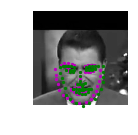

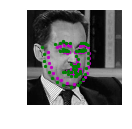

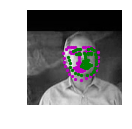

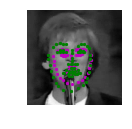

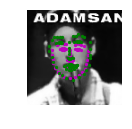

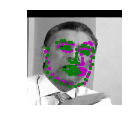

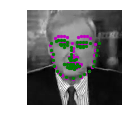

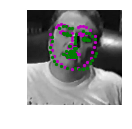

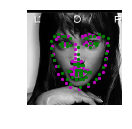

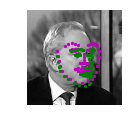

In [21]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [22]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'my_keypoints_model_3.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Adam optimizer and Mean Squared Error were chosen. I followed the suggestions in the recommended paper and found these choices to perform relatively well.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I tried by adding convolutional layers followed by pooling layers. At some pointI flattened them and added several fully connected layers. The first attempt was made by following the exact same structure as in the original paper with 4 convolutional and pooling layers and 3 fully connected layers including the last layer. Then I decided to remove the middle layer because I want to have sufficiently large neurons to map to the final output size of 136. Dropout layers are added in every step to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I chose a relatively small batch size of 20. Originally I trained for 10 epochs and finally ended up with 40 epochs to reach a certain level of small error.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06057705  0.09244371 -0.22098809  0.13885592 -0.23975451]
 [-0.25227627 -0.08979698 -0.2046326   0.02671744  0.12585093]
 [ 0.10930432  0.12611228 -0.16709761  0.1137882  -0.03104409]
 [-0.25211388 -0.14906666  0.04141151 -0.02437276 -0.14453954]
 [-0.17720969  0.00620819  0.00214726  0.08493444  0.12855724]]
(5, 5)


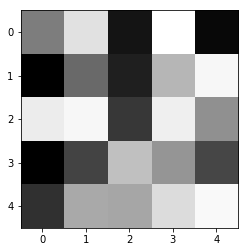

In [23]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 22

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

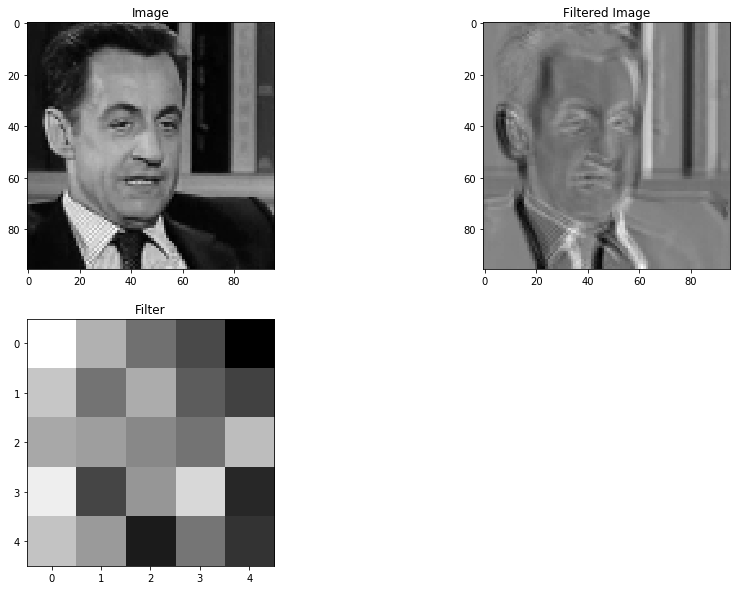

In [27]:
##TODO: load in and display any image from the transformed test dataset
import cv2
image = test_images[1].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.squeeze(np.transpose(image, (1, 2, 0)))  # transpose to go from torch to numpy image
weights1 = net.conv1.weight.data
w = weights1.numpy()
filter_index = 4
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered = cv2.filter2D(image, -1, w[filter_index][0])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax.imshow(image, cmap = 'gray')
ax.set_title("Image")
ax = fig.add_subplot(222)
ax.imshow(filtered, cmap = 'gray')
ax.set_title("Filtered Image")
ax = fig.add_subplot(223)
ax.imshow(w[filter_index][0], cmap = 'gray')
ax.set_title("Filter")
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: As observed from the example above, the chosen filter applies a kind of edge detection effect on the image by contrasting between the left and right of horizontal lines. This allows it pick up strong components in vertical lines and effectively detect certain edges with strong black and white contrast.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!